In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd


from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import euclidean
from sklearn.neighbors import NearestNeighbors


In [2]:
class AnomalyPredictor:
    def __init__(self):
        self.model = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def create_model(self):
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(2,)),  # Adjust input shape
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(2)  # Output layer: [magnetic_anomaly, gravity_anomaly]
        ])
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        self.model = model

    def train(self, X, y, epochs=50, batch_size=128):
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        y_pred_scaled = self.model.predict(X_scaled)
        return self.scaler_y.inverse_transform(y_pred_scaled)


In [3]:
import os
os.getcwd()
os.chdir('/Users/juanmanuelpaiba/Documents/Juan_Paiba/BairesDev/geophysical_nn_data')

In [4]:
# Read the Parquet file
file_path = 'Data/Outputs/nn_data.gzip.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

In [5]:
print(df.shape)
df.head()

(2000000, 4)


,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal
3091797,8.92,189.68,-8.4,-0.086023
2079975,29.92,329.32,40.8,-0.132539
995513,52.12,241.48,-11.4,-0.682569
5719008,-44.92,135.08,-5.7,-0.019397
6024424,-52.02,90.28,2.5,-0.707683


In [6]:
# Create a smaller sample
sample_size = 70000  # Adjust this number as needed
df_sample = df.sample(n=sample_size, random_state=42)

In [7]:
# Define X and y
X = df_sample[['latitude', 'longitude']]
y = df_sample[['grav_anom','Magnetic_Anomaly_mGal']]

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Create and train the model
predictor = AnomalyPredictor()
predictor.create_model()
history = predictor.train(X, y, epochs=50, batch_size=64)

Epoch 1/50
766/766 [==============================] - 1s 806us/step - loss: 0.9645 - mae: 0.6283 - val_loss: 0.9501 - val_mae: 0.6202
Epoch 2/50
766/766 [==============================] - 1s 840us/step - loss: 0.9309 - mae: 0.6105 - val_loss: 0.9234 - val_mae: 0.6032
Epoch 3/50
766/766 [==============================] - 1s 824us/step - loss: 0.9128 - mae: 0.5994 - val_loss: 0.9077 - val_mae: 0.5917
Epoch 4/50
766/766 [==============================] - 1s 885us/step - loss: 0.8990 - mae: 0.5903 - val_loss: 0.8952 - val_mae: 0.5843
Epoch 5/50
766/766 [==============================] - 1s 758us/step - loss: 0.8878 - mae: 0.5825 - val_loss: 0.8831 - val_mae: 0.5777
Epoch 6/50
766/766 [==============================] - 1s 953us/step - loss: 0.8803 - mae: 0.5776 - val_loss: 0.8784 - val_mae: 0.5747
Epoch 7/50
766/766 [==============================] - 1s 905us/step - loss: 0.8740 - mae: 0.5734 - val_loss: 0.8767 - val_mae: 0.5729
Epoch 8/50
766/766 [==============================] - 1s 732us

In [10]:
X_test.head()

,latitude,longitude
6928984,-70.22,148.62
4079028,-11.75,96.98
2297206,25.52,211.68
4311478,-16.42,58.18
2026538,31.25,30.28


In [11]:
X_test_scaled = StandardScaler().fit_transform(X_test)

In [12]:
# Make predictions using the subset
y_pred = predictor.predict(X_test)

438/438 [==============================] - 0s 342us/step


In [13]:
# Calculate Mean Absolute Error (MAE) for Magnetic_Anomaly_mGal
mae_mag = mean_absolute_error(y_test['Magnetic_Anomaly_mGal'], y_pred[:, 1])

# Calculate Mean Squared Error (MSE) for Magnetic_Anomaly_mGal
mse_mag = mean_squared_error(y_test['Magnetic_Anomaly_mGal'], y_pred[:, 1])

# Calculate Root Mean Squared Error (RMSE) for Magnetic_Anomaly_mGal
rmse_mag = np.sqrt(mse_mag)

print(f'Magnetic Anomaly - Mean Absolute Error (MAE): {mae_mag}')
print(f'Magnetic Anomaly - Mean Squared Error (MSE): {mse_mag}')
print(f'Magnetic Anomaly - Root Mean Squared Error (RMSE): {rmse_mag}')

Magnetic Anomaly - Mean Absolute Error (MAE): 0.5439827789427583
Magnetic Anomaly - Mean Squared Error (MSE): 0.8672824605180846
Magnetic Anomaly - Root Mean Squared Error (RMSE): 0.931280011875099


In [14]:
# Calculate Mean Absolute Error (MAE) for grav_anom
mae_grav = mean_absolute_error(y_test['grav_anom'], y_pred[:, 0])

# Calculate Mean Squared Error (MSE) for grav_anom
mse_grav = mean_squared_error(y_test['grav_anom'], y_pred[:, 0])

# Calculate Root Mean Squared Error (RMSE) for grav_anom
rmse_grav = np.sqrt(mse_grav)

print(f'Gravity Anomaly - Mean Absolute Error (MAE): {mae_grav}')
print(f'Gravity Anomaly - Mean Squared Error (MSE): {mse_grav}')
print(f'Gravity Anomaly - Root Mean Squared Error (RMSE): {rmse_grav}')

Gravity Anomaly - Mean Absolute Error (MAE): 11.637700167705127
Gravity Anomaly - Mean Squared Error (MSE): 392.03091979533366
Gravity Anomaly - Root Mean Squared Error (RMSE): 19.799770700574634


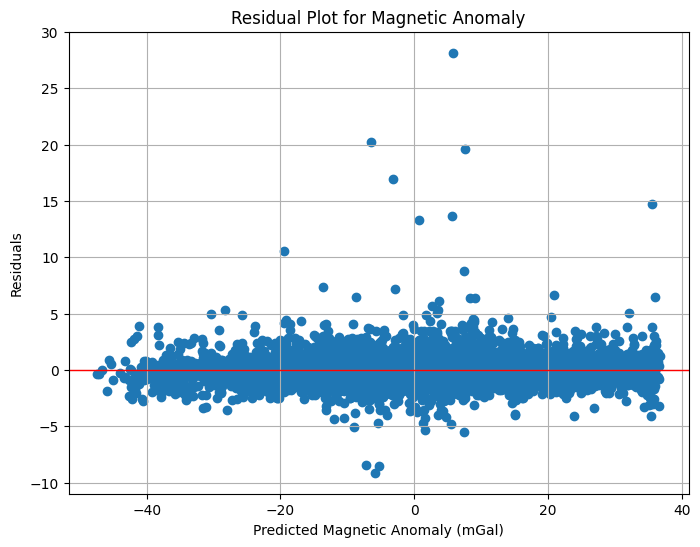

In [15]:
# Calculate residuals for Magnetic_Anomaly_mGal
residuals_mag = y_test['Magnetic_Anomaly_mGal'] - y_pred[:, 1]

# Plot residuals against predicted values for Magnetic_Anomaly_mGal
plt.figure(figsize=(8, 6))
plt.scatter(y_pred[:, 0], residuals_mag)
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Predicted Magnetic Anomaly (mGal)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Magnetic Anomaly')
plt.grid(True)
plt.show()

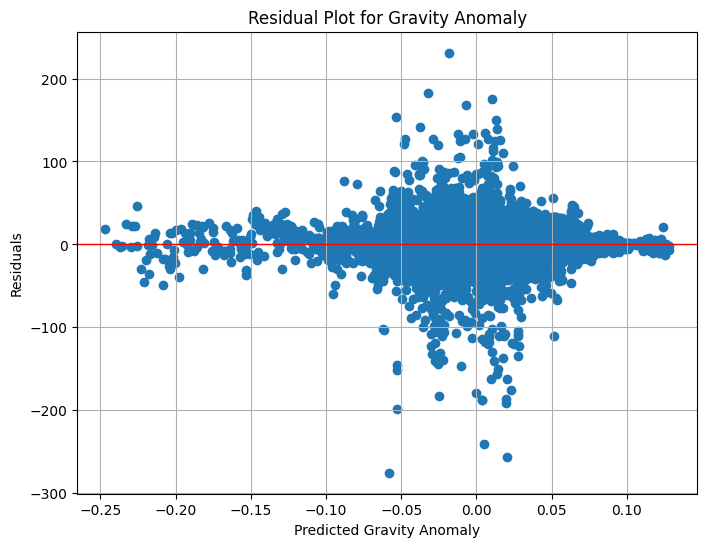

In [16]:
# Calculate residuals for grav_anom
residuals_grav = y_test['grav_anom'] - y_pred[:, 0]

# Plot residuals against predicted values for grav_anom
plt.figure(figsize=(8, 6))
plt.scatter(y_pred[:, 1], residuals_grav)
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Predicted Gravity Anomaly')
plt.ylabel('Residuals')
plt.title('Residual Plot for Gravity Anomaly')
plt.grid(True)
plt.show()

### Evaluate a model, and comparison with real data

In [17]:
# Create a smaller sample
df_test = df.sample(n=1000, random_state=42)

In [18]:
X_test_2 = df_test[['latitude', 'longitude']]

In [19]:
df_test.head()

,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal
4308682,-16.38,238.68,-0.2,-0.175178
6117001,-53.62,189.28,-2.9,-0.383910
1452739,43.15,111.78,-13.7,0.275191
1101834,50.38,95.98,-23.2,-0.092593
2246973,26.75,189.88,-16.3,0.955683


In [20]:
# Make predictions using the subset
y_pred_2 = predictor.predict(X_test_2)

32/32 [==============================] - 0s 521us/step


In [21]:
# Add y_pred[:, 0] as 'grav_anom_pred' and y_pred[:, 1] as 'magnetic_anom_pred' to df_test
df_test['grav_anom_pred'] = y_pred_2[:, 0]
df_test['magnetic_anom_pred'] = y_pred_2[:, 1]

In [22]:
df_test.head(3)

,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal,grav_anom_pred,magnetic_anom_pred
4308682,-16.38,238.68,-0.2,-0.175178,-0.258438,-0.021177
6117001,-53.62,189.28,-2.9,-0.383910,-22.747940,0.013986
1452739,43.15,111.78,-13.7,0.275191,-11.528503,0.040861


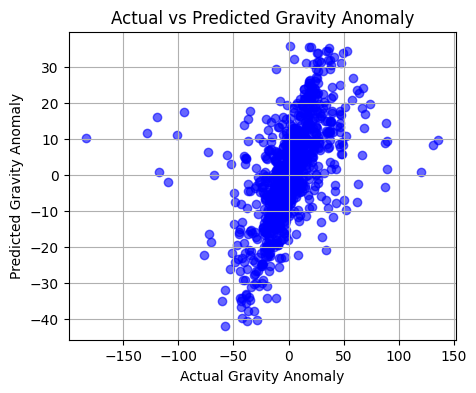

In [23]:
# Scatter plot of grav_anom vs grav_anom_pred
plt.figure(figsize=(5, 4))
plt.scatter(df_test['grav_anom'], df_test['grav_anom_pred'], color='blue', alpha=0.6)
plt.title('Actual vs Predicted Gravity Anomaly')
plt.xlabel('Actual Gravity Anomaly')
plt.ylabel('Predicted Gravity Anomaly')
plt.grid(True)
plt.show()

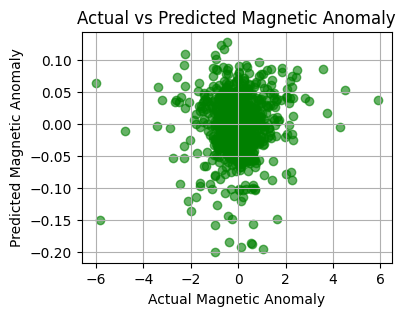

In [24]:
# Scatter plot of grav_anom vs grav_anom_pred
plt.figure(figsize=(4, 3))
plt.scatter(df_test['Magnetic_Anomaly_mGal'], df_test['magnetic_anom_pred'], color='green', alpha=0.6)
plt.title('Actual vs Predicted Magnetic Anomaly')
plt.xlabel('Actual Magnetic Anomaly')
plt.ylabel('Predicted Magnetic Anomaly')
plt.grid(True)
plt.show()

### creating class multidimensionalVAP

In [25]:
class MultiDimensionalVAP:
    def __init__(self, dataframe):
        self.data = dataframe
        self.nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(self.data[['latitude', 'longitude']])
    
    def add_vap(self, latitude, longitude, grav_anom, Magnetic_Anomaly_mGal):
        new_vap = pd.DataFrame({
            'latitude': [latitude],
            'longitude': [longitude],
            'grav_anom': [grav_anom],
            #'elevation': [elevation],
            'Magnetic_Anomaly_mGal': [Magnetic_Anomaly_mGal]
            
          #  'pressure': [pressure]
        })
        self.data = pd.concat([self.data, new_vap], ignore_index=True)
        self.nbrs.fit(self.data[['latitude', 'longitude']])
    
    def find_nearest_vaps(self, latitude, longitude, num_vaps=3):
        distances, indices = self.nbrs.kneighbors([[latitude, longitude]], n_neighbors=num_vaps)
        return self.data.iloc[indices[0]]
    
    def interpolate_position(self, vaps, **kwargs):
        """
        Interpolates the position based on given readings.
        
        Parameters:
        vaps (pd.DataFrame): DataFrame containing VAPs data.
        **kwargs: Arbitrary keyword arguments containing latitude, longitude,
                  magnetic_reading, gravity_reading.
        
        Returns:
        dict: A dictionary containing the interpolated position and readings.
        """
        # Retrieve values from kwargs
        latitude = kwargs.get('latitude', None)
        longitude = kwargs.get('longitude', None)
        gravity_reading = kwargs.get('grav_anom', None)
        magnetic_reading = kwargs.get('Magnetic_Anomaly_mGal', None)
        
        
        if latitude is None or longitude is None:
            raise ValueError("Latitude and longitude must be provided.")
        
        # Calculate weights based on inverse distance
        distances = vaps.apply(lambda row: euclidean((row['latitude'], row['longitude']), (latitude, longitude)), axis=1)
        weights = 1 / distances
        weights /= weights.sum()  # Normalize weights to sum to 1
        
        # Perform weighted average interpolation for latitude and longitude
        interpolated_latitude = np.sum(weights * vaps['latitude'])
        interpolated_longitude = np.sum(weights * vaps['longitude'])
        
        # For elevation, you can implement interpolation logic here if elevation data is available
        
        # Return interpolated values along with provided readings
        return {
            'latitude': interpolated_latitude,
            'longitude': interpolated_longitude,
            'gravity_anomaly': gravity_reading,
            'magnetic_field': magnetic_reading
        }

In [26]:
class EnhancedMultiDimensionalVAP(MultiDimensionalVAP):
    def __init__(self, db_path):
        super().__init__(db_path)
        self.anomaly_predictor = AnomalyPredictor()
        self.train_predictor()

    def train_predictor(self):
        # Fetch all VAP data
        #self.cursor.execute('SELECT latitude, longitude, magnetic_anomaly, gravity_anomaly FROM multi_vaps')
        data = self.data[['latitude', 'longitude', 'grav_anom','Magnetic_Anomaly_mGal']]
        X = data[['latitude', 'longitude']].values
        y = data[['grav_anom','Magnetic_Anomaly_mGal']].values
        
        self.anomaly_predictor.create_model()
        self.anomaly_predictor.train(X, y)

    def predict_anomalies(self, lat, lon):
        X = np.array([[lat, lon]])
        y_pred = self.anomaly_predictor.predict(X)
        return y_pred[0]
        
    def interpolate_position(self, vaps, latitude=None, longitude=None, gravity_reading=None, magnetic_reading=None):
        if latitude is None or longitude is None:
            raise ValueError("Latitude and longitude must be provided.")

        if len(vaps) < 3:  # If we have very sparse data
            # Predict anomalies for the current location
            predicted_anomalies = self.predict_anomalies(latitude, longitude)

            # Create a DataFrame with the new row
            new_row = pd.DataFrame({
                'latitude': [latitude],
                'longitude': [longitude],
                'grav_anom': [predicted_anomalies[0]],
                'Magnetic_Anomaly_mGal': [predicted_anomalies[1]],
            })

            # Combine the original DataFrame with the new row
            combined_vaps = pd.concat([vaps, new_row], ignore_index=True)

            return super().interpolate_position(combined_vaps, gravity_reading, magnetic_reading)
        else:
            # Calculate weights based on inverse distance
            distances = vaps.apply(lambda row: euclidean((row['latitude'], row['longitude']), (latitude, longitude)), axis=1)
            weights = 1 / distances
            weights /= weights.sum()  # Normalize weights to sum to 1
            
            # Perform weighted average interpolation for latitude and longitude
            interpolated_latitude = np.sum(weights * vaps['latitude'])
            interpolated_longitude = np.sum(weights * vaps['longitude'])
            
            # For gravity and magnetic fields, take the average (or apply custom logic as needed)
            interpolated_gravity_anomaly = np.mean(vaps['grav_anom'])
            interpolated_magnetic_field = np.mean(vaps['Magnetic_Anomaly_mGal'])

            # Return interpolated values along with provided readings
            return {
                'latitude': interpolated_latitude,
                'longitude': interpolated_longitude,
                'gravity_anomaly': interpolated_gravity_anomaly,
                'magnetic_field': interpolated_magnetic_field,
            }
        
    def calculate_confidence(self, vaps, gravity_reading, magnetic_reading):
        """
        Calculate the confidence of the interpolation based on the VAPs data and the readings.

        Parameters:
        vaps (pd.DataFrame): DataFrame containing VAPs data.
        magnetic_reading (float): Magnetic field reading.
        gravity_reading (float): Gravity anomaly reading.

        Returns:
        float: Confidence value (0 to 1).
        """
        if len(vaps) < 2:
            return 0.5  # If less than 2 VAPs, return a low confidence by default

        # Calculate distance-based confidence
        lat_mean = vaps['latitude'].mean()
        lon_mean = vaps['longitude'].mean()
        distances = np.sqrt((vaps['latitude'] - lat_mean)**2 + (vaps['longitude'] - lon_mean)**2)
        distance_confidence = 1 - np.mean(distances)  # Closer VAPs give higher confidence

        # Calculate reading variance-based confidence
        magnetic_variance = vaps['Magnetic_Anomaly_mGal'].var()
        gravity_variance = vaps['grav_anom'].var()
        reading_variance = (magnetic_variance + gravity_variance) / 3
        reading_confidence = 1 / (1 + reading_variance)  # Lower variance gives higher confidence

        # Combine both confidences
        combined_confidence = (distance_confidence + reading_confidence) / 2

        # Ensure confidence is between 0 and 1
        return max(0, min(1, combined_confidence))


In [27]:
X_test

,latitude,longitude
6928984,-70.22,148.62
4079028,-11.75,96.98
2297206,25.52,211.68
4311478,-16.42,58.18
2026538,31.25,30.28
...,...,...
6993628,-71.55,238.98
3309499,4.45,349.38
2043444,31.15,61.12
1036156,51.85,285.08


In [28]:
# Usage example
vap_system = EnhancedMultiDimensionalVAP(df_sample)

Epoch 1/50
383/383 [==============================] - 1s 950us/step - loss: 0.9736 - mae: 0.6326 - val_loss: 0.9602 - val_mae: 0.6223
Epoch 2/50
383/383 [==============================] - 0s 745us/step - loss: 0.9434 - mae: 0.6170 - val_loss: 0.9335 - val_mae: 0.6078
Epoch 3/50
383/383 [==============================] - 0s 861us/step - loss: 0.9242 - mae: 0.6061 - val_loss: 0.9204 - val_mae: 0.6014
Epoch 4/50
383/383 [==============================] - 0s 787us/step - loss: 0.9118 - mae: 0.5986 - val_loss: 0.9087 - val_mae: 0.5926
Epoch 5/50
383/383 [==============================] - 0s 958us/step - loss: 0.9010 - mae: 0.5917 - val_loss: 0.9031 - val_mae: 0.5908
Epoch 6/50
383/383 [==============================] - 0s 767us/step - loss: 0.8924 - mae: 0.5857 - val_loss: 0.8892 - val_mae: 0.5794
Epoch 7/50
383/383 [==============================] - 0s 786us/step - loss: 0.8829 - mae: 0.5787 - val_loss: 0.8788 - val_mae: 0.5722
Epoch 8/50
383/383 [==============================] - 0s 818us

In [29]:
# Add some sample VAPs (this would typically be done with real data)
vap_system.add_vap(-33.98, 140.38, 1481.0, 0.097864)
vap_system.add_vap(28.15, 60.42, 1301.7, -0.785708)

In [30]:
# Find nearest VAPs
nearest_vaps = vap_system.find_nearest_vaps(4.5, 282.4196, num_vaps=4) 

/Users/juanmanuelpaiba/.pyenv/versions/3.8.17/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [31]:
nearest_vaps

,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal
33170,4.38,282.22,-7.7,0.002042
18470,4.65,282.62,50.3,0.070678
47236,4.18,281.72,17.3,-0.212573
56041,4.18,281.68,21.0,-0.212472


In [32]:
# Example usage with keyword arguments
estimated_position = vap_system.interpolate_position(
    nearest_vaps,
    latitude=4.5,
    longitude=272.4196
)

print(estimated_position)

{'latitude': 4.340018987268402, 'longitude': 282.0447680033413, 'gravity_anomaly': 20.224999999999998, 'magnetic_field': -0.08808103573422732}


In [33]:
# Calculate confidence
confidence = vap_system.calculate_confidence(nearest_vaps, 35, 0.6)

In [34]:
print(f"Estimated position: {estimated_position}")
print(f"Confidence: {confidence}")

# Predict anomalies for a new location
predicted_anomalies = vap_system.predict_anomalies(37.7752, -122.4197)
print(f"Predicted anomalies: Magnetic = {predicted_anomalies[0]}, Gravity = {predicted_anomalies[1]}")

Estimated position: {'latitude': 4.340018987268402, 'longitude': 282.0447680033413, 'gravity_anomaly': 20.224999999999998, 'magnetic_field': -0.08808103573422732}
Confidence: 0.3033874182717345
1/1 [==============================] - 0s 32ms/step
Predicted anomalies: Magnetic = -4.948750972747803, Gravity = 0.35518550872802734
